Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [30]:
import torch
import re
import pandas as pd
import numpy as np
import nltk

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from string import punctuation
from textblob import TextBlob, Word
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from itertools import islice
from pathlib import Path
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AlenWolker\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
!pip install stop-words pymorphy2

In [32]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [33]:
DATASET_FILEPATH =  Path('kaggle/twitter-sentiment-analysis-hatred-speech/')
max_words = 2000
max_len = 20
num_classes = 1
epochs = 10
batch_size = 512
print_batch_n = 100
TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'
CSV_train = DATASET_FILEPATH.joinpath(TRAIN_CSV)
CSV_test = DATASET_FILEPATH.joinpath(TEST_CSV)
df_train = pd.read_csv(CSV_train)
df_test = pd.read_csv(CSV_test)
df_train['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

In [43]:
max_words = 2500
max_len = 25
num_classes = 1

# Training
epochs = 5
batch_size = 512
print_batch_n = 100
df = pd.read_csv("kaggle/twitter-sentiment-analysis-hatred-speech/train.csv")

In [50]:
df['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

In [44]:
df_train.tail(5).style.background_gradient(cmap = "summer")

,id,label,tweet
31957,31958,0,ate @user isz that youuu?ðððððððððâ¤ï¸
31958,31959,0,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher
31959,31960,0,listening to sad songs on a monday morning otw to work is sad
31960,31961,1,"@user #sikh #temple vandalised in in #calgary, #wso condemns act"
31961,31962,0,thank you @user for you follow


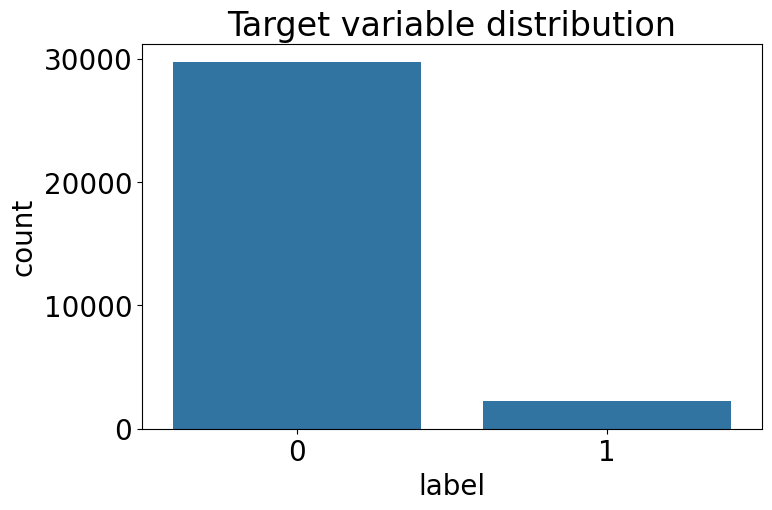

In [49]:
plt.figure(figsize=(8, 5))

sns.countplot(x='label', data=df)

plt.title('Target variable distribution')
plt.show()

In [48]:
# функция балансировки классов: 

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)
# провожу балансировку классов целевой переменной: 

df_for_balancing = df
target_name = 'label'
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

AttributeError: 'DataFrame' object has no attribute 'append'

In [51]:
plt.figure(figsize=(8, 5))

sns.countplot(x=target_name, data=df_balanced)

plt.title('Target variable distribution after balancing')
plt.show()

NameError: name 'df_balanced' is not defined

<Figure size 800x500 with 0 Axes>

In [52]:
df_train, df_val = train_test_split(df_balanced, test_size=0.3, random_state=42) #shuffle=True, stratify=df['label'], )

NameError: name 'df_balanced' is not defined

In [ ]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [ ]:
sw = set(get_stop_words("en"))

In [ ]:
new_sw = {'im', 'u', 'us', '2', '2016', '4', '2017', 'ive', '3', '1', 'r', 'iam', 's', 'n', '10', 'ur', 'w', '8', '5', 'd', 'shes', '7', 'b', 'ag', 'bc', '6', 'x', '12', 'gt', 'whos', '1st', 'self', '50', 't', 'y'}

sw = sw.union(new_sw) 

sw, len(sw)

In [ ]:
puncts = set(punctuation)

In [ ]:
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
#     txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [ ]:
df_train['tweet'].iloc[:1].values

In [ ]:
df_train['tweet'].iloc[:1].apply(preprocess_text).values

In [ ]:
from tqdm import tqdm
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

  0%|          | 1/31962 [00:00<?, ?it/s]


NameError: name 'puncts' is not defined

In [ ]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

In [ ]:
tokens_filtered = [word for word in tokens if word.isalnum()]
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

In [ ]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [ ]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [ ]:
%%time

x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch

class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

In [ ]:
from torch import nn

class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)

        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)

        out = self.linear(last_tensor)
        return torch.sigmoid(out)
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [ ]:
%%time

gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    gru_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
         # выводим статистику о процессе обучения
    gru_init.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

print('Training is finished!')

In [ ]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)

        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)
lstm_init = LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

In [ ]:
%%time

lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
         # выводим статистику о процессе обучения
    lstm_init.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

print('Training is finished!')

Вывод: обе архитектуры подходят для решения подобного рода задач.